# Notebook created 02/08/2024 - This notebook runs the kinematic extraction on all objects with xshooter library
#### 02/13/2024 - Continuing to debug, testing the library differences between xshooter and emiles
#### 02/14/2024 - Now testing J0029 full bin kinematics with the two libraries
#### 02/15/2024 - Running and saving the kinematics for each of the 14 with both libraries.


In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pathlib # to create directory
import dill as pickle
from datetime import datetime
import os

from ppxf.ppxf import ppxf
from pathlib import Path
from scipy import ndimage
from urllib import request
from scipy import ndimage
from time import perf_counter as clock
from scipy import interpolate
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
import astropy.units as u
from vorbin.voronoi_2d_binning import voronoi_2d_binning


# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/ppxf_kcwi_util_022423")
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/")

from slacs_kcwi_kinematics import slacs_kcwi_kinematics

c = 299792.458 # km/s

In [2]:
#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

In [3]:
# Universal parameters
# todays date
date = datetime.now().strftime("%Y_%m_%d")
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
kinematics_dir = f'{data_dir}kinematics/{date}/'
if not os.path.exists(kinematics_dir):
    os.mkdir(kinematics_dir)
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# aperture
aperture = 'R2'
# wavelength range
wave_min = 3400
wave_max = 4300 ########### NOTE J0330 will be different
# degree of the additive Legendre polynomial in ppxf
degree = 4 # 900/250 = 3.6 round up
#------------------------------------------------------------------------------
# Information specific to KCWI and templates
kcwi_scale = 0.1457
## R=3600. spectral resolution is ~ 1.42A
FWHM_data = 1.42 #1.42
## initial estimate of the noise
noise = 0.014
# velocity scale ratio
velscale_ratio = 2
# FWHM of templates
FWHM_xshooter = 0.403 # Angstroms
FWHM_emiles = 2.51 # Angstroms
# central wavelength is where we measure FWHM
central_wavelength = 3950
#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions
# cut the datacube at lens center, radius given here
radius_in_pixels = 21
# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
bin_target_SN = 15.
# minimum SN of pixels to be included in voronoi bining
pixel_min_SN = 1.
# stellar population
sps_names = ['xshooter','emiles']


library_vds = np.zeros((len(obj_names), len(sps_names)))


__________
# J0029

In [4]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0029-0055'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.227 # lens redshift
T_exp = 1800*5 # exposure time in seconds... this is where I made the disastrous mistake
lens_center_x,lens_center_y = 61, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'

mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'
plot_bin_fits=False

j = 0

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [5]:
percent_bins_mean = np.zeros(14)
percent_inner_bins = np.zeros_like(percent_bins_mean)
percent_outer_bins = np.zeros_like(percent_bins_mean)

# Do a full bin treatment of J0029

#######################################################################

xshooter

pPXF will now consume your soul and use it to measure the kinematics of SDSSJ0029-0055.


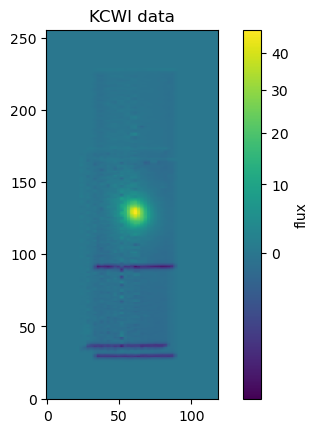

Templates do not cover galaxy lower wavelength range. Adding zeros.
Check this fit to be sure the 0s are not in the fit range.
 Best Fit:       Vel     sigma
 comp.  0:       291       231
chi2/DOF: 0.1684; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 18/629


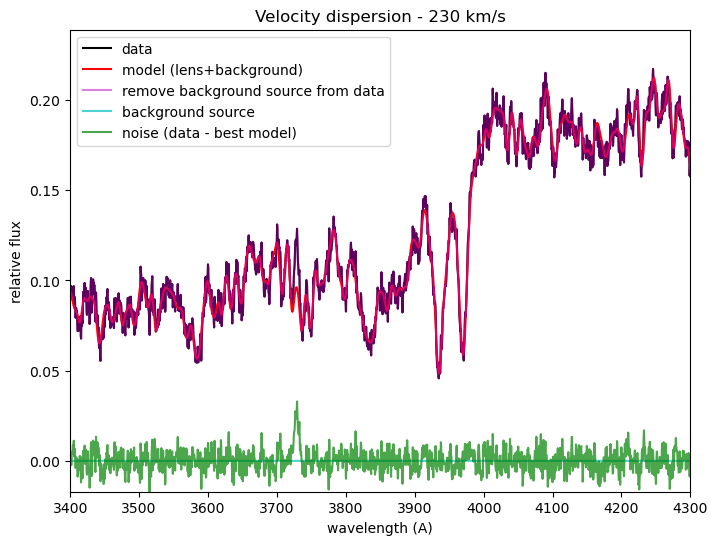

Formal errors:
     dV    dsigma   dh3      dh4
       4     4.1
Elapsed time in pPXF: 3.47 s


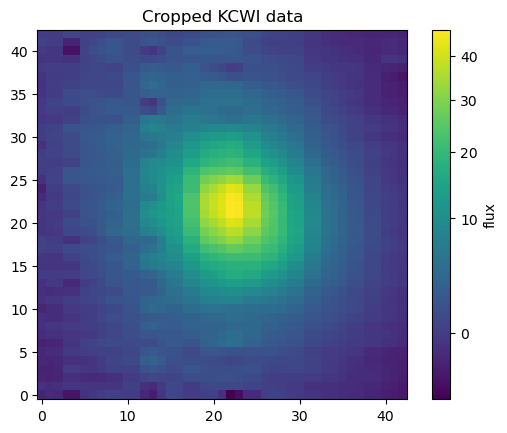

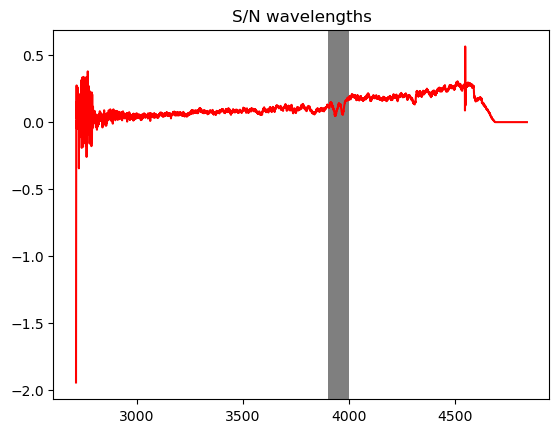

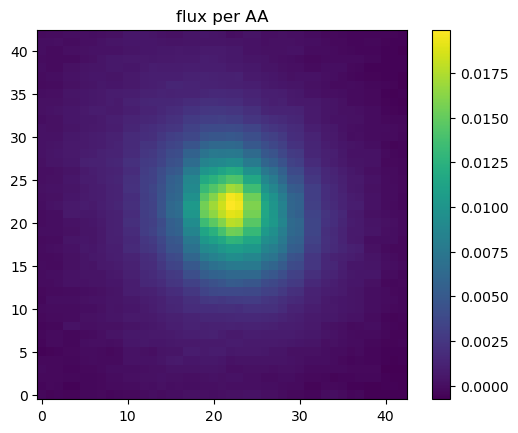

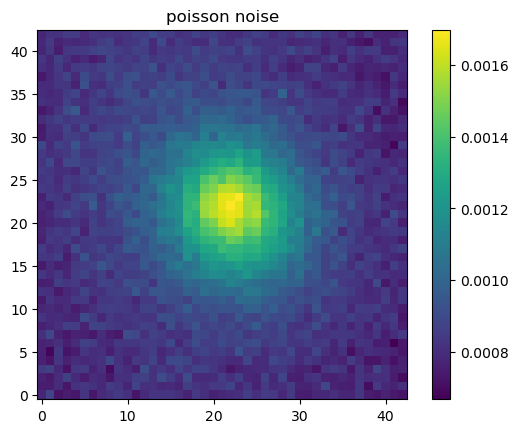

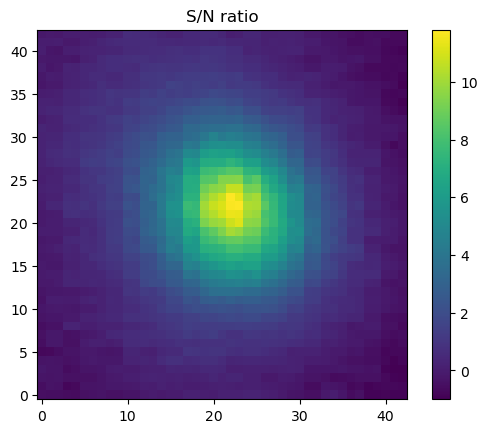

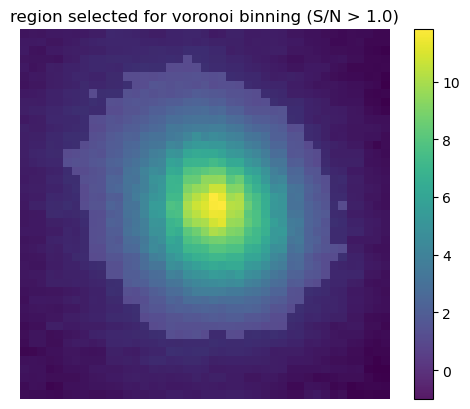

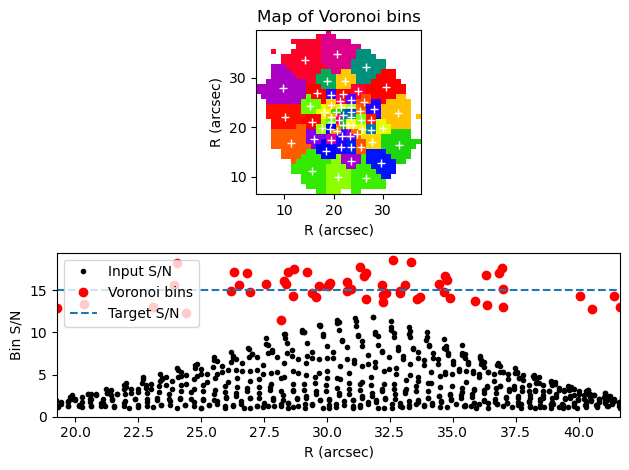

Number of bins = 59


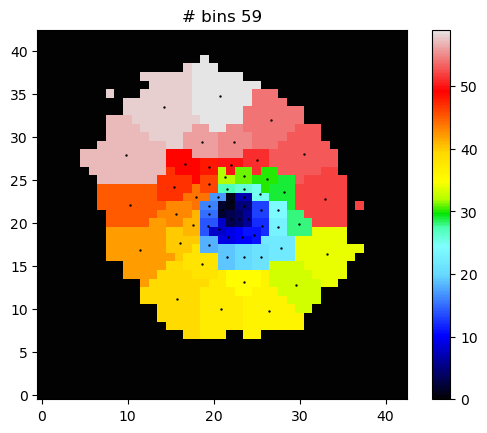

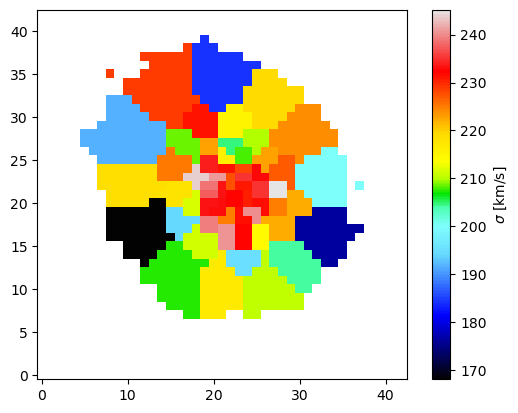

<Figure size 640x480 with 0 Axes>

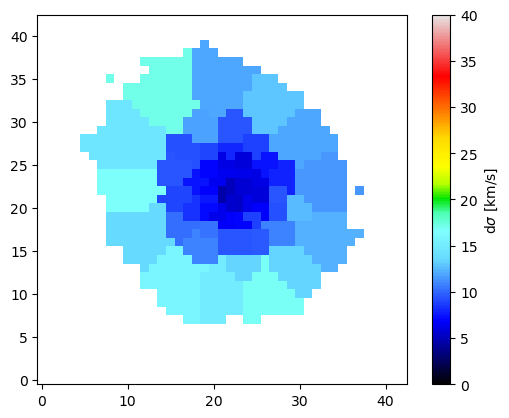

<Figure size 640x480 with 0 Axes>

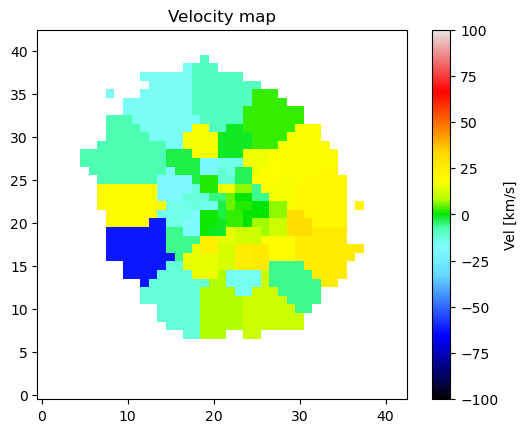

<Figure size 640x480 with 0 Axes>

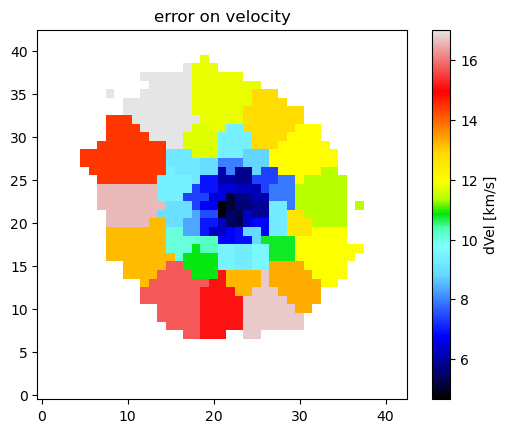

Job's finished!


<Figure size 640x480 with 0 Axes>

In [6]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()


# save it
#if not os.path.exists(kin_dir):
#    os.mkdir(kin_dir)
#with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
#    if sps_name=='xshooter':
#        pickle.dump(x_kinematics, file)
#    elif sps_name=='emiles':
#        pickle.dump(e_kinematics, file)

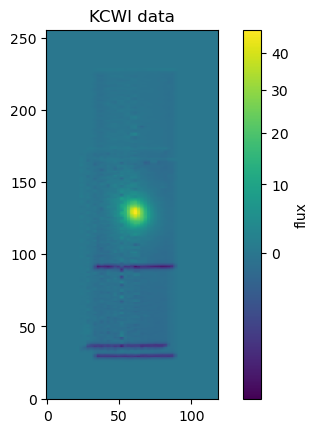

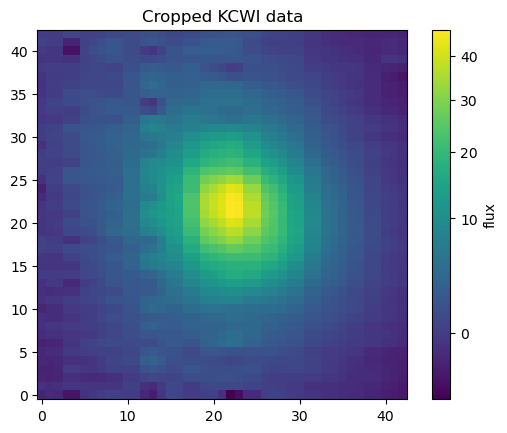

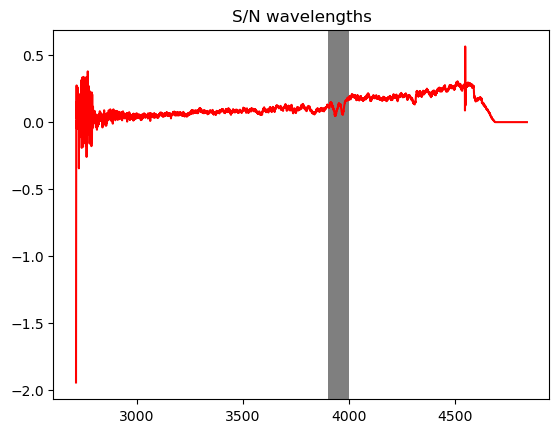

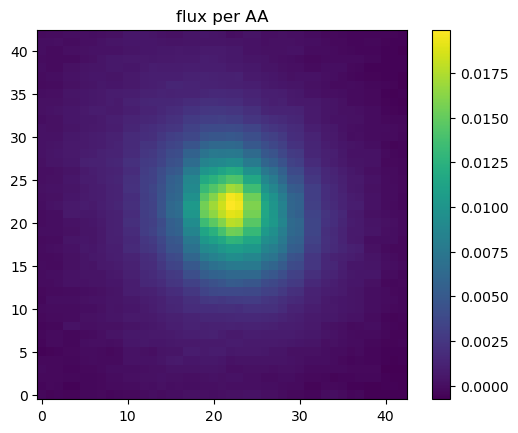

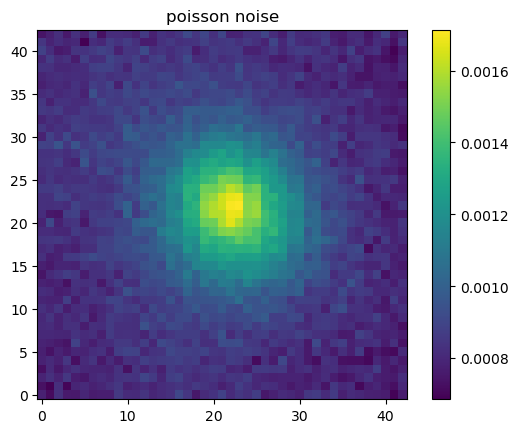

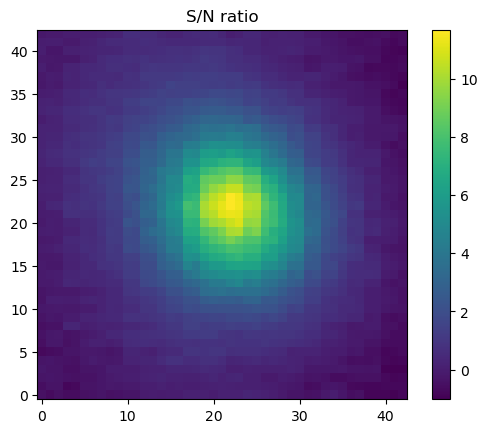

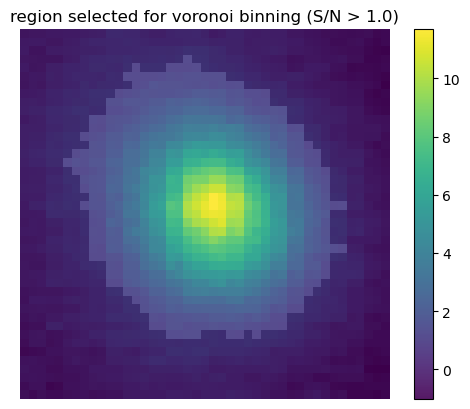

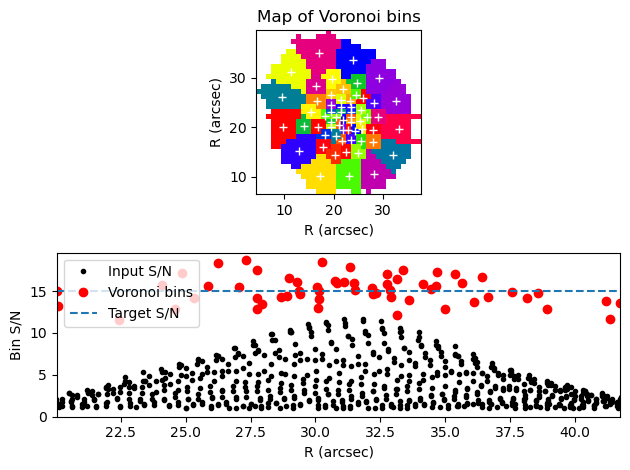

Number of bins = 60


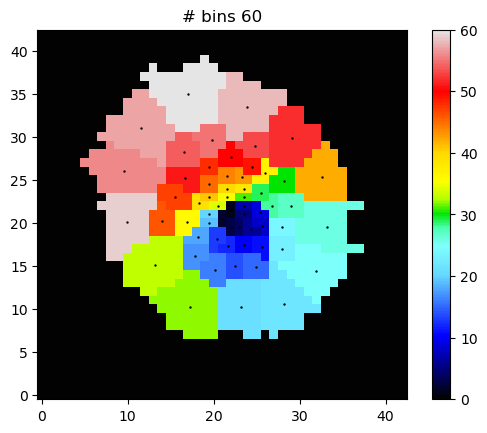

In [8]:
# Visualize the summed datacube
x_kinematics.datacube_visualization()

# rebin the central spectrum in log wavelengths and prepare for fitting
x_kinematics.log_rebin_central_spectrum()

# same with background spectrum
#x_kinematics.log_rebin_background_spectrum()

# prepare the templates from the sps model
#x_kinematics.get_templates()

# set up the wavelengths that will be fit, masks a couple gas lines
#x_kinematics.set_up_mask()

# fit the central spectrum to create the global_template
#x_kinematics.ppxf_central_spectrum()

# crop the datacube to a smaller size
x_kinematics.crop_datacube()

# create a S/N map to get the Voronoi binning going
x_kinematics.create_SN_map()

# select the spaxels S/N > 1 that will be binned
x_kinematics.select_region()

# bin the selected spaxels to the target S/N
x_kinematics.voronoi_binning()

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

percent_bins_mean

percent_inner_bins

percent_outer_bins

__________
# J0037

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0037-0942'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.195 # lens redshift
T_exp = 1800*3 # This has been corrected
lens_center_x,lens_center_y = 59, 137
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


j = 1

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD
    
    
    

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J0330

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0330-0020'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.351 # lens redshift
#z_bs = 1.071 # background source redshift... additional piece for contamination
T_exp = 1800*6 # fixed
lens_center_x,lens_center_y = 59, 133
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# wavelength range
wave_min_j0330 = 3400
wave_max_j0330 = 4100 # shorter wave range because higher redshift
# degree of the additive Legendre polynomial in ppxf
degree_j0330 = 3 # 70/25 = 2.8 round up
#------------------------------------------------------------------------------
#KCWI mosaic datacube
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = f'{mos_dir}{obj_abbr}_background_source_mask.reg'


j=2

for i, sps_name in enumerate(sps_names):
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                                 mos_dir=mos_dir,
                                                 kin_dir=kin_dir,
                                                 obj_name=obj_name,
                                                 kcwi_datacube_file=kcwi_datacube,
                                                 central_spectrum_file=central_spectrum_file,
                                                 background_spectrum_file=None,
                                                 background_source_mask_file=background_source_mask_file,
                                                 zlens=zlens,
                                                 exp_time=T_exp,
                                                 lens_center_x=lens_center_x,
                                                 lens_center_y=lens_center_y,
                                                 aperture=aperture,
                                                 wave_min=wave_min_j0330, # diff because higher redshift cuts off above 4100 A
                                                 wave_max=wave_max_j0330,
                                                 degree=degree_j0330,
                                                 sps_name=sps_name,
                                                 pixel_scale=kcwi_scale,
                                                 FWHM_data=FWHM_data,
                                                 FWHM_templates=FWHM_templates,
                                                 central_wavelength=central_wavelength,
                                                 noise=noise,
                                                 velscale_ratio=velscale_ratio,
                                                 radius_in_pixels=radius_in_pixels,
                                                 bin_target_SN=bin_target_SN,
                                                 pixel_min_SN=pixel_min_SN,
                                                 plot=True,
                                                 quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                              mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min_j0330, # diff because higher redshift cuts off above 4100 A
                                             wave_max=wave_max_j0330,
                                             degree=degree_j0330,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM_data=FWHM_data,
                                             FWHM_templates=FWHM_templates,
                                             central_wavelength=central_wavelength,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min_j0330, # diff because higher redshift cuts off above 4100 A
                                             wave_max=wave_max_j0330,
                                             degree=degree_j0330,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM_data=FWHM_data,
                                             FWHM_templates=FWHM_templates,
                                             central_wavelength=central_wavelength,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1112

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1112+0826'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.273 # lens redshift
z_bs = 0.629
T_exp = 1800*4 # this has been fixed.
lens_center_x,lens_center_y = 64, 131
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 3

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1204

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1204+0358'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.164 # lens redshift
T_exp = 1800*4 # this has been corrected
lens_center_x,lens_center_y = 60, 135
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


j = 4

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1250

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1250+0523'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.232 # lens redshift
T_exp = 1800*3 # this has been corrected
lens_center_x,lens_center_y = 53, 127
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


j = 5

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()


# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1306

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1306+0600'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.173 # lens redshift
T_exp = 1800*3 + 1500 # corrected #266 * 60
lens_center_x,lens_center_y = 56, 137
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


j = 6

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1402

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1402+6321'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.205 # lens redshift
T_exp = 1800*4 # corrected
lens_center_x,lens_center_y = 57, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 7

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1531

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1531-0105'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.16 # lens redshift
T_exp = 1200*4 # corrected # I removed frame 32 which was 80 seconds... couldn't find center to make the mosiac... #+ 80*60 #266 * 60
lens_center_x,lens_center_y = 60, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 8

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1538

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1538+5817'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.143 # lens redshift
T_exp = 1800*2 # this has been corrected
lens_center_x,lens_center_y = 58, 119
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 9

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1621

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1621+3931'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.245 # lens redshift
T_exp = 1200*6 # corrected
lens_center_x,lens_center_y = 58, 126 #30, 99
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 10

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1627

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1627-0053'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.208 # lens redshift
T_exp = 1800*5 + 960 # corrected #266 * 60
lens_center_x,lens_center_y = 56, 134
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 11

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J1630

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1630+4520'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.248 # lens redshift
T_exp = 1800*4 + 1180 #266 * 60
lens_center_x,lens_center_y = 59, 131
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 12

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD

In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

# J2303

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ2303+1422'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.155 # lens redshift
T_exp = 1800*3 # corrected
lens_center_x,lens_center_y = 58, 124
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

j = 13

for i, sps_name in enumerate(sps_names):
    
    print('#######################################################################')
    print()
    print(sps_name)
    print()
    
    if sps_name == 'xshooter':
        FWHM_templates = FWHM_xshooter
    elif sps_name == 'emiles':
        FWHM_templates = FWHM_emiles
    
    kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             FWHM_templates=FWHM_templates,
                                             FWHM_data=FWHM_data,
                                             pixel_scale=kcwi_scale,
                                             noise=noise,
                                             central_wavelength=central_wavelength,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
    )

    # rebin the central spectrum in log wavelengths and prepare for fitting
    kinematics.log_rebin_central_spectrum()
    # same with background spectrum
    kinematics.log_rebin_background_spectrum()
    # prepare the templates from the sps model
    kinematics.get_templates()
    # set up the wavelengths that will be fit, masks a couple gas lines
    kinematics.set_up_mask()
    # fit the central spectrum to create the global_template
    kinematics.ppxf_central_spectrum()
    
    library_vds[j,i] = kinematics.central_spectrum_VD


In [ ]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

x_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

x_kinematics.run_slacs_kcwi_kinematics()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

In [ ]:
# emiles

sps_name = 'emiles'

print('#######################################################################')
print()
print(sps_name)
print()

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

e_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

# Visualize the summed datacube
e_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
e_kinematics.log_rebin_central_spectrum()
# same with background spectrum
e_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
e_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
e_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
e_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
e_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
e_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
e_kinematics.select_region()
# bin the selected spaxels to the target S/N
e_kinematics.voronoi_binning()
# replace the voronoi binning info with that form xshooter fit so they have the same bins
print('replace the voronoi binning info with that form xshooter fit so they have the same bins')
e_kinematics.nbins = x_kinematics.nbins
e_kinematics.voronoi_binning_data = x_kinematics.voronoi_binning_data
e_kinematics.voronoi_binning_output = x_kinematics.voronoi_binning_output
# fit each bin spectrum with global_template
e_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)
# create the 2d kinematic maps from ppxf fits
e_kinematics.make_kinematic_maps()
# plot those maps
e_kinematics.plot_kinematic_maps()

# save it
if not os.path.exists(kin_dir):
    os.mkdir(kin_dir)
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date}.pkl', 'wb') as file:
    if sps_name=='xshooter':
        pickle.dump(x_kinematics, file)
    elif sps_name=='emiles':
        pickle.dump(e_kinematics, file)

x_vd = x_kinematics.bin_kinematics[:,1]
e_vd = e_kinematics.bin_kinematics[:,1]
resid_vd = e_vd - x_vd
percent_vd = resid_vd / x_vd * 100

rbin = np.sqrt(np.sum((x_kinematics.bin_centers-21)**2, axis=1))*kcwi_scale
inner_bins = np.argwhere(rbin<0.5)
outer_bins = np.argwhere(rbin>0.5)

percent_bins_mean[j] = np.nanmean(percent_vd) 
percent_inner_bins[j] = np.nanmean(percent_vd[inner_bins])
percent_outer_bins[j] = np.nanmean(percent_vd[outer_bins])

vmin = np.nanmin((np.nanmin(e_kinematics.VD_2d), np.nanmin(x_kinematics.VD_2d)))
vmax = np.nanmax((np.nanmax(e_kinematics.VD_2d), np.nanmax(x_kinematics.VD_2d)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[0].set_title('xshooter')
im = ax[1].imshow(e_kinematics.VD_2d, origin='lower', cmap='sauron', vmin=vmin, vmax=vmax)
ax[1].set_title('emiles')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical', label='km/s')
plt.pause(1)
             
resid_bins = e_kinematics.VD_2d - x_kinematics.VD_2d
percent_diff = resid_bins / x_kinematics.VD_2d * 100

plt.imshow(resid_bins, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(resid_bins)), vmax = np.nanmax(abs(resid_bins)))
plt.title(f'mean: {np.around(np.nanmean(resid_vd), 2)}, std: {np.around(np.nanstd(resid_vd), 2)}')
plt.colorbar(label='resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.hist(resid_vd.ravel(), bins=np.linspace(-np.nanmax(abs(resid_vd)), np.nanmax(abs(resid_vd)), 10))
plt.axvline(np.nanmean(resid_vd), color='k')
plt.xlabel('resid(emiles - xshooter) [km/s]')
plt.pause(1)

plt.imshow(percent_diff, origin='lower', cmap='seismic', vmin = -np.nanmax(abs(percent_diff)), vmax = np.nanmax(abs(percent_diff)))
plt.title(f'mean: {np.around(np.nanmean(percent_vd), 2)}, std: {np.around(np.nanstd(percent_vd), 2)}')
plt.colorbar(label='% resid(emiles - xshooter)/xshooter')
plt.pause(1)

plt.hist(percent_vd.ravel(), bins=np.linspace(-np.nanmax(abs(percent_vd)), np.nanmax(abs(percent_vd)), 10))
plt.axvline(np.nanmean(percent_vd), color='k')
plt.xlabel('% resid(emiles - xshooter)/xshooter')
plt.pause(1)

In [ ]:
Stop here

# Take a look at teh results

In [ ]:
plt.scatter(range(14),percent_bins_mean)

In [ ]:
mean_effect

In [ ]:
library_effect = (library_vds[:,1] - library_vds[:,0])/library_vds[:,0]*100
mean_effect = np.mean(library_effect)
std_effect = np.std(library_effect)

labels=['xshooter','emiles']

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax[0].scatter(range(14), library_vds[:,0], c='k', label=labels[0], alpha=0.7)
ax[0].scatter(range(14), library_vds[:,1], c='r', label=labels[1], alpha=0.7)
ax[0].legend()
ax[0].set_ylabel(r'$\sigma$ km/s')
ax[1].scatter(range(14), library_effect, c='k', alpha=0.7, marker='o', label='aperture', zorder=100)
ax[1].scatter(range(14), percent_bins_mean, c='g', alpha=0.7, marker='s', label='bin')
ax[1].scatter(range(14), percent_inner_bins, c='b', alpha=0.7, marker='<', label='inner')
ax[1].scatter(range(14), percent_outer_bins, c='purple', alpha=0.7, marker='>', label='outer')
ax[1].axhline(mean_effect, c='k', label=f'mean {np.around(mean_effect, 2)}')
ax[1].axhline(mean_effect-std_effect, c='k', linestyle=':')
ax[1].axhline(mean_effect+std_effect, c='k', linestyle=':', label=f'std {np.around(std_effect, 2)}')
ax[1].fill_between(range(-1,15), mean_effect-std_effect, mean_effect+std_effect, color='grey', alpha=0.2)
ax[1].set_ylim(-5.5, 5.5)
ax[1].set_xlim(-1,14)
ax[1].set_ylabel('% difference')
ax[1].legend(bbox_to_anchor=(1.0, 1.5))
plt.tight_layout()

In [ ]:
# rotate through, highlighting the jth one each time

for j in range(len(obj_names)):

    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    # all of them
    ax[0].scatter(range(14), library_vds[:,0], c='k', alpha=0.2)
    ax[0].scatter(range(14), library_vds[:,1], c='r', alpha=0.2)
    # jth
    ax[0].scatter(j, library_vds[j,0], c='k', label=labels[0], alpha=0.8)
    ax[0].scatter(j, library_vds[j,1], c='r', label=labels[1], alpha=0.8)
    ax[0].legend()
    ax[0].set_ylabel(r'$\sigma$ km/s')
    ax[0].set_title(obj_names[j])
    # lower plot
    # all of them
    ax[1].scatter(range(14), library_effect, c='k', alpha=0.2, marker='o', zorder=100)
    ax[1].scatter(range(14), percent_bins_mean, c='g', alpha=0.2, marker='s')
    ax[1].scatter(range(14), percent_inner_bins, c='b', alpha=0.2, marker='<', )
    ax[1].scatter(range(14), percent_outer_bins, c='purple', alpha=0.2, marker='>', )
    # jth
    ax[1].scatter(j, library_effect[j], c='k', alpha=0.8, marker='o', label='aperture', zorder=100)
    ax[1].scatter(j, percent_bins_mean[j], c='g', alpha=0.8, marker='s', label='bin')
    ax[1].scatter(j, percent_inner_bins[j], c='b', alpha=0.8, marker='<', label='inner')
    ax[1].scatter(j, percent_outer_bins[j], c='purple', alpha=0.8, marker='>', label='outer')
    ax[1].axhline(mean_effect, c='k', label=f'mean {np.around(mean_effect, 2)}')
    ax[1].axhline(mean_effect-std_effect, c='k', linestyle=':')
    ax[1].axhline(mean_effect+std_effect, c='k', linestyle=':', label=f'std {np.around(std_effect, 2)}')
    ax[1].fill_between(range(-1,15), mean_effect-std_effect, mean_effect+std_effect, color='grey', alpha=0.2)
    ax[1].set_ylim(-5.5, 5.5)
    ax[1].set_xlim(-1,14)
    ax[1].set_ylabel('% difference')
    ax[1].legend(bbox_to_anchor=(1.0, 1.5))
    plt.tight_layout()

In [ ]:
np.nanmean(percent_inner_bins)

In [ ]:
np.nanmean(percent_outer_bins)

In [ ]:
np.nanmean(percent_outer_bins - percent_inner_bins)

In [ ]:
percent_outer_bins - percent_inner_bins

In [ ]:
np.nanmean(percent_bins_mean)

In [ ]:
# squash